<a href="https://colab.research.google.com/github/SanBartolome/IA-diploma-course-2021/blob/main/Optimizacion_continua_Desafio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimizacion Industrial con Computacion Evolutiva
<b> Diplomatura de Especialización en Desarrollo de Aplicaciones con Inteligencia Artificial</b>

Dr. Edwin Villanueva (ervillanueva@pucp.edu.pe)

## DESAFIO: Algoritmo Genetico para optimización continua

En este desafio vamos a experimentar un algoritmo Genético para minimizar funciones continuas. 
Abajo se tiene implementado un AG basico. Se pide implementar el operador de cruzamiento aritmetrico completo (metodo crossover_arithmetic() en la clase Individual) 

Al final de este notebook encontrará las preguntas que serán evaluadas

Funcion Ackley <img src="https://www.sfu.ca/~ssurjano/ackley.png"> 
Funcion Rastrigin <img src="https://es.mathworks.com/help/gads/rastrigins_with_line2.png">

### Librerias a usar

In [1]:
import sys
import time
import random
import numpy as np
from copy import deepcopy
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import heapq
import math

## Estructura de individuo 

In [2]:
class Individual(object):   
   
    def __init__(self, chromosome):
            self.chromosome = chromosome[:]
            self.fitness = -1  # -1 indica que el individuo no ha sido evaluado
             
    def crossover_onepoint(self, other):
        "Retorna dos nuevos individuos del cruzamiento de un punto entre individuos self y other "
        c = random.randrange(len(self.chromosome))
        ind1 = Individual(self.chromosome[:c] + other.chromosome[c:])
        ind2 = Individual(other.chromosome[:c] + self.chromosome[c:])
        return [ind1, ind2]   

    def crossover_uniform(self, other):
        chromosome1 = []
        chromosome2 = []
        "Retorna dos nuevos individuos del cruzamiento uniforme entre self y other "
        for i in range(len(self.chromosome)):
            if random.uniform(0, 1) < 0.5:
                chromosome1.append(self.chromosome[i])
                chromosome2.append(other.chromosome[i])
            else:
                chromosome1.append(other.chromosome[i])
                chromosome2.append(self.chromosome[i])
        ind1 = Individual(chromosome1)
        ind2 = Individual(chromosome2)
        return [ind1, ind2] 
    
    def crossover_arithmetic(self, other):
        """ Cruzamiento aritmetrico completo de los cromosomas de self con other. Genera hijos:
            chromosome1 = alpha*self + (1−alpha)*other
            chromosome2 = alpha*other + (1−alpha)*self
        """
        
        #TO DO: Desarrollo su código 
        alpha = random.random()
        chromosome1 = []
        chromosome2 = []
        for i in range(len(self.chromosome)):
          chromosome1.append(alpha*self.chromosome[i]+(1-alpha)*other.chromosome[i])
          chromosome2.append(alpha*other.chromosome[i]+(1-alpha)*self.chromosome[i])
        ind1 = Individual(chromosome1)
        ind2 = Individual(chromosome2)
        return [ind1, ind2] 
    
    
    
    
  
    def mutate_singlegene(self, intensity_mutation): 
        """ Perturba un alelo (coordenada) de un gen (dimension) ."""
        mutated_chromosome = deepcopy(self.chromosome)
        mutGene = random.randrange(0,len(mutated_chromosome)) 
        newAllele = mutated_chromosome[mutGene] + random.uniform(-1,1) * intensity_mutation * mutated_chromosome[mutGene] 
        mutated_chromosome[mutGene] = newAllele
        
        return Individual(mutated_chromosome)    
        
    def mutate_allgenes(self, intensity_mutation):
        "Perturba todo el cromosoma sumando un vector aleatorio pequeño "
        module_chromosome = math.sqrt(sum(i**2 for i in self.chromosome))  # calcula el modulo del cromosoma
        perturbation_vector = [ module_chromosome * intensity_mutation * random.uniform(-1, 1) for j in range(len(self.chromosome))]
        mutated_chromosome =  [sum(x) for x in zip(*[self.chromosome, perturbation_vector])]  # suma el cromosoma con el vector perturbacion 

        return Individual(mutated_chromosome)    

### Funcion para obtener el fitness de un cromosoma

In [3]:
# convierte el valor de la funcion de minimizacion fn en un valor de fitness (maximizacion) para el chromosome pasado
def fitness(fn, chromosome):  
    # el fitness para fn positivos es trasladado a valores entre [0,1]: 0 para fn=inf y 1 para fn=0. 
    # el fitness para fn negativos es trasladado a valores entre ]1,inf]: 1 para fn=-0 y inf para fn=-inf    
    
    result = fn(chromosome)
    if result >= 0:
        fitness = 1 / (1 + result)
    else:
        fitness =  1 + abs(result)
    return fitness

### Funcion para evaluar una población de individuos 

In [4]:
def evaluate_population(population, fn):
    """ Evalua una poblacion de individuos para la funcion de optimizacion fn """
    
    for i in range(len(population)):
        if population[i].fitness == -1:    # si el individuo no esta evaluado
            population[i].fitness = fitness(fn, population[i].chromosome)
    return population

### Funcion para inicializar aleatoriamente una población de individuos


In [5]:
def init_population(pop_number, chromosome_size, space_limits, seed=0):
    population = []
    np.random.seed(seed)
    
    ## Crea la poblacion inicial con cromosomas aleatorios
    for i in range(pop_number):
        new_chromosome = np.ndarray.tolist(np.random.uniform(low=space_limits[0], high=space_limits[1], size=chromosome_size))
        population.append(Individual(new_chromosome))

    return population

<b>  Funcion para mostrar una población y su fitnes  </b> 

In [6]:
def display(population):
    listaAG=[]
    for i in range(len(population)):
        listaAG.append([population[i].chromosome,population[i].fitness])

    data=pd.DataFrame(listaAG)
    data.columns = ['Poblacion','fitness']
    return data

### Operadores de seleccion de padres

#### Seleccion por Ruleta

In [7]:
def select_parents_roulette(population):
    popsize = len(population)
    iParent1,iParent2=0,0
    # Escoje el primer padre
    sumfitness = sum([indiv.fitness for indiv in population])  # suma total del fitness de la poblacion
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        cumfitness += population[i].fitness
        if cumfitness >= pickfitness: 
            iParent1 = i
            break
     
    # Escoje el segundo padre, desconsiderando el padre ya escogido
    sumfitness = sumfitness - population[iParent1].fitness # retira el fitness del padre ya escogido
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        if i == iParent1: continue   # si es el primer padre 
        cumfitness += population[i].fitness
        if cumfitness >= pickfitness: 
            iParent2 = i
            break        
    return (population[iParent1], population[iParent2])

#### Seleccion por Torneo

In [8]:
def select_parents_torneo(population,size_torneo):
    
    # Escoje el primer padre
    list_indiv=[]
    x1 = np.random.permutation(len(population) )
    y1= x1[0:size_torneo]
    for i in range(size_torneo):
        list_indiv.append(population[y1[i]].fitness)
    
    iParent1=np.argmax(list_indiv)
    
    # Escoje el segundo padre, desconsiderando el primer padre   
    x2 = np.delete(x1, iParent1)
    x2 = np.random.permutation(x2)
    list_indiv=[]
    y2= x2[0:size_torneo]
    for i in range(size_torneo):
        list_indiv.append(population[y2[i]].fitness)
    iParent2=np.argmax(list_indiv)
    
    return (population[x1[iParent1]],population[x2[iParent2]])

### Operadores de Seleccion de sobrevivientes


#### Función de selección de la poblacion para la sgte generación por ranking
Selecciona la población siguiente ranqueando los individuos de la poblacion actual (population) y la poblacion descendencia (offspring_population) y escogiendo los mejores numsurvivors  individuos 

In [9]:
def select_survivors_ranking(population, offspring_population, numsurvivors):
    next_population = []
    population.extend(offspring_population) # une las dos poblaciones
    isurvivors = sorted(range(len(population)), key=lambda i: population[i].fitness,reverse=True)[:numsurvivors]
    for i in range(numsurvivors): 
        next_population.append(population[isurvivors[i]])
    return next_population

## Algoritmo Genetico para buscar una solucion de valor minimo de la funcion continua fn 
Recibe una poblacion inicial, funcion a minimizar fn, numero de generaciones (ngen), taza de mutación (pmut), operador de cruzamiento (crossover), operador de mutacion (mutation), metodo de seleccion de padres (selection_parents_method) y metodo de seleccion de sobrevivientes (selection_survivors_method) 

In [10]:
def genetic_algorithm(poblacion_inicial, fn, ngen=100, pmut=0.1, intensity_mut=0.5, 
                      crossover="onepoint", mutation="singlegene", 
                      selection_parents_method="roulette", 
                      selection_survivors_method="ranking"):
    """Algoritmo Genetico para encontrar un minimo de la funcion fn
        ngen:       maximo numero de generaciones 
        pmut:       tasa de mutacion
        crossover:  operador de cruzamiento
        mutation:   operador de mutacion
        selection_parents_method: método de selección de padres para cruzamiento
        selection_survivors_method: método de selección de sobrevivientes 
    """
    population = deepcopy(poblacion_inicial)  # copia la poblacion inicial en una nueva variable para no alterar la inicial
    
    popsize = len(population)
    evaluate_population(population, fn)  # evalua la poblacion inicial
    ibest = sorted(range(len(population)), key=lambda i: population[i].fitness)[:1]

    bestfitness = [population[ibest[0]].fitness]
    print("Poblacion inicial, best_fitness = {}".format(population[ibest[0]].fitness))
    
    for g in range(ngen):   # Por cada generacion
        
       ## Selecciona las parejas de padres para cruzamiento 
        mating_pool = []
  
        if selection_parents_method=="roulette":
            for i in range(int(popsize/2)): mating_pool.append(select_parents_roulette(population)) 
        elif selection_parents_method=="tournament" :
            for i in range(int(popsize/2)): mating_pool.append(select_parents_torneo(population,3)) 
        else:
            raise NotImplementedError

        ## Crea la poblacion descendencia cruzando las parejas del mating pool 
        offspring_population = []
        for i in range(len(mating_pool)): 
            if crossover == "onepoint":  
                offspring_population.extend( mating_pool[i][0].crossover_onepoint(mating_pool[i][1]) ) # cruzamiento 1 punto
            elif crossover == "uniform": 
                offspring_population.extend( mating_pool[i][0].crossover_uniform(mating_pool[i][1]) ) # cruzamiento uniforme
            elif crossover == "arithmetic": 
                offspring_population.extend( mating_pool[i][0].crossover_arithmetic(mating_pool[i][1]) ) # cruzamiento aritmetico
            else:
                raise NotImplementedError

        ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
        for i in range(len(offspring_population)):
            if random.uniform(0, 1) < pmut: 
                if mutation == "singlegene":
                    offspring_population[i] = offspring_population[i].mutate_singlegene(intensity_mut)   # mutacion un gen
                elif mutation == "allgenes":
                    offspring_population[i] = offspring_population[i].mutate_allgenes(intensity_mut) # muta todos los genes
                else:
                    raise NotImplementedError
        
        ## Evalua la poblacion descendencia creada
        evaluate_population(offspring_population, fn)  
        
        ## Selecciona individuos para la sgte. generación 
        if selection_survivors_method == "ranking":
            population = select_survivors_ranking(population, offspring_population, popsize) #metodo de ranking
        else:
            raise NotImplementedError

        ## Almacena la historia del fitness del mejor individuo
        ibest = sorted(range(len(population)), key=lambda i: population[i].fitness)[:1]
        bestfitness.append(population[ibest[0]].fitness)
        print("generacion {}, best_fitness = {}, best_chromosoma = {}".format(g, population[ibest[0]].fitness,population[ibest[0]].chromosome))
    
    return population[ibest[0]], bestfitness, population[ibest[0]].chromosome

## Probando el Algoritmo genetico en funciones de minimizacion ackley y rastringin

#### Funcion Ackley:

$$f(x_0 \cdots x_n) = -20 exp(-0.2 \sqrt{\frac{1}{n} \sum_{i=1}^n x_i^2}) - exp(\frac{1}{n} \sum_{i=1}^n cos(2\pi x_i)) + 20 + e$$ 

$$-20 \leq x_i \leq 20$$ 

$$\text{minimum at }f(0, \cdots, 0) = 0$$

In [11]:
def ackley(chromosome, *, a=20, b=0.2, c=2*np.pi):
    sum_part1 = np.sum([x**2 for x in chromosome])
    part1 = -1.0 * a * np.exp(-1.0 * b * np.sqrt((1.0/len(chromosome)) * sum_part1))
    sum_part2 = np.sum([np.cos(c * x) for x in chromosome])
    part2 = -1.0 * np.exp((1.0 / len(chromosome)) * sum_part2)

    return a + np.exp(1) + part1 + part2

#### Funcion Rastrigin:

$$f(x_1 \cdots x_n) = 10n + \sum_{i=1}^n (x_i^2 -10cos(2\pi x_i))$$ 
$$-5 \leq x_i \leq 5$$ 
$$\text{minimum at }f(0, \cdots, 0) = 0$$

In [12]:
def rastrigin(chromosome):
    sum_i = np.sum([x**2 - 10*np.cos(2 * np.pi * x) for x in chromosome])
    return 10 * len(chromosome) + sum_i

#### Define parametros, inicializa poblacion  y ejecuta  algoritmo genetico

Poblacion inicial, best_fitness = 0.04493493484605271
generacion 0, best_fitness = 0.04878392448931465, best_chromosoma = [2.8078708167151873, 17.171847903048565]
generacion 1, best_fitness = 0.0592671002892251, best_chromosoma = [0.8739328700028679, 8.60757465489678]
generacion 2, best_fitness = 0.07342383669455062, best_chromosoma = [4.483828908896857, 2.7373579547459386]
generacion 3, best_fitness = 0.08914875190106583, best_chromosoma = [0.8739328700028679, -4.2093309556075225]
generacion 4, best_fitness = 0.10729647389400675, best_chromosoma = [0.5252124947764965, -2.4559394615071852]
generacion 5, best_fitness = 0.13028950476176232, best_chromosoma = [0.5252124947764965, -1.9127450340178946]
generacion 6, best_fitness = 0.1304683688268907, best_chromosoma = [0.5252124947764965, 1.7953273198758737]
generacion 7, best_fitness = 0.14278505029955454, best_chromosoma = [0.8739328700028679, 1.7953273198758737]
generacion 8, best_fitness = 0.1633201180705935, best_chromosoma = [2.041321

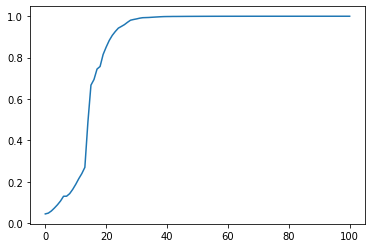

In [13]:
limits_ackley = [-20,20]    # limite inferior y superior de cada coordenada de la poblacion para ackley
limits_rastrigin = [-5,5]  #  limite inferior y superior de cada coordenada de la poblacion para rastrigin
fn_dimensions = 2  # numero de dimensiones de la funcion

# parametros del AG
num_individuals = 50
ngen = 100 # numero de generaciones
pmut = 0.2 # prob. mutation
imut = 0.5 # intensity of mutation
crossover=['onepoint','uniform','arithmetic']
mutation=['singlegene','allgenes']
metodoSeleccion=['roulette','tournament'] 

# Inicializa una poblacion inicial de forma aleatoria
seed = 0  # para generar la misma poblacion inicial
#seed = datetime.now()  # para generar una poblacion inicial diferente cada vez que se corre
poblacion_inicial = init_population(num_individuals, fn_dimensions, limits_ackley, seed)


# Ejecuta la optimizacion con el AG
best_ind, best_fitness, best_chromosoma = genetic_algorithm(poblacion_inicial, ackley,  # ackley
                                                            ngen, pmut, imut, 
                                                            crossover[1], mutation[1], metodoSeleccion[0])  
    
plt.plot(best_fitness)                
plt.show()

# Preguntas:

<b>1) Compare el desempeño de los operadores de cruzamiento (uniform vs arithmetic)</b>

Se debe colocar la tasa de mutación = 0</b> (a fin de centrarnos solo en el efecto de cruzamiento) y ejecutar 10 corridas en  en funcion ackley, 20 dimensiones. Usar limits_ackley para generar las poblaciones iniciales segun corresponda. En cada corrida se debe:
    - Generar una poblacion inicial P con un seed diferente (puede usar datetime.now())
    - Ejecutar el AG con poblacion inicial P y metodo de cruzamiento uniform
    - Ejecutar el AG con poblacion inicial P y metodo de cruzamiento arithmetic
    - En ambas ejecuciones registre el fitness máximo obtenido y la primera generacion donde se obtiene dicho fitness
Los parametros del AG para cada corrida son 50 individuos, 300 generaciones, seleccion de padres = 'roulette'

Comparar los promedios de fitness máximos y generaciones de convergencia. Cuál operador tiende a encontrar mejores soluciones y Cuál tiende a convergir mas rapido?. Explique por qué

In [14]:
limits_ackley = [-20,20]    # limite inferior y superior de cada coordenada de la poblacion para ackley
limits_rastrigin = [-5,5]  #  limite inferior y superior de cada coordenada de la poblacion para rastrigin
fn_dimensions = 20  # numero de dimensiones de la funcion

# parametros del AG
num_individuals = 50
ngen = 300 # numero de generaciones
pmut = 0 # prob. mutation
imut = 0.5 # intensity of mutation
crossover=['uniform','arithmetic']
mutation='singlegene'
metodoSeleccion='roulette' 

# Inicializa una poblacion inicial de forma aleatoria
seed = datetime.now().microsecond  # para generar una poblacion inicial diferente cada vez que se corre
poblacion_inicial = init_population(num_individuals, fn_dimensions, limits_ackley, seed)


# Ejecuta la optimizacion con el AG
crossover_fitness = []
crossover_converge_generator = []
j = 0
for cross in crossover:
  crossover_fitness.append([])
  crossover_converge_generator.append([])
  for ind in range(10):
    best_ind, best_fitness, best_chromosoma = genetic_algorithm(poblacion_inicial, ackley,  # ackley
                                                            ngen, pmut, imut, 
                                                            cross, mutation, metodoSeleccion)
    crossover_fitness[j].append(best_ind.fitness)
    crossover_converge_generator[j].append(best_fitness.index(best_ind.fitness))
  j = j + 1

Se truncaron las últimas líneas 5000 del resultado de transmisión.
generacion 116, best_fitness = 0.10205853823525154, best_chromosoma = [-0.2879452608673603, 1.467831631669256, -1.870676775257877, 1.2753214313737438, 6.580132692157001, 3.7935943504150202, -2.045925684543782, 1.0896575787555598, -0.8896315563051331, 2.684165181275123, -2.714232921550952, -0.9229879871208553, 0.4435918607088283, -0.9649439882072883, 0.04040070478442814, 1.7229820390740933, 1.051360214046607, 0.33865127590357247, 0.4154586871772281, 2.9431032718583907]
generacion 117, best_fitness = 0.10205853823525154, best_chromosoma = [-0.2879452608673603, 1.467831631669256, -1.870676775257877, 1.2753214313737438, 6.580132692157001, 3.7935943504150202, -2.045925684543782, 1.0896575787555598, -0.8896315563051331, 2.684165181275123, -2.714232921550952, -0.9229879871208553, 0.4435918607088283, -0.9649439882072883, 0.04040070478442814, 1.7229820390740933, 1.051360214046607, 0.33865127590357247, 0.4154586871772281, 2.94310

In [15]:
print('uniform')
print('best fitness mean: ', np.array(crossover_fitness[0]).mean())
print('first converge generator mean: ', np.array(crossover_converge_generator[0]).mean())
print('arithmethic')
print('best fitness mean: ', np.array(crossover_fitness[1]).mean())
print('first converge generator mean: ', np.array(crossover_converge_generator[1]).mean())

uniform
best fitness mean:  0.09934784967850811
first converge generator mean:  36.3
arithmethic
best fitness mean:  0.11779880265081566
first converge generator mean:  155.8


Uniforme converge primero y aritmético tiene mejor fitness, esto se puede deber a que en uniforme la aletoriedad en la selección de hijos permite encontrar un buen fitness pero pierde la solución parcialmente óptima mientras busca el mejor fitness, en caso del aritmético debido a las operaciones que realiza no pierde del todo la solución y obtiene un mejor fitness.

<b>2) Evalue el operador e tasa de mutacion </b>
    
Realize 10 corridas en (ackley, 20 dimensiones) con el operador de cruzamiento arithmetic y configuraciones de mutacion siguientes: (mutate_singlegene, pmut=0.1), (mutate_singlegene, pmut=0.9), (mutate_allegenes, pmut=0.1), (mutate_allegenes, pmut=0.9). Usar intensidad de mutacion imut = 0.5. En cada corrida se debe: 
    - Generar una poblacion inicial P con un seed diferente (puede usar datetime.now())
    - Ejecutar el AG con poblacion inicial P y configuracion de mutacion (mutate_singlegene, pmut=0.1)
    - Ejecutar el AG con poblacion inicial P y configuracion de mutacion (mutate_singlegene, pmut=0.9)
    - Ejecutar el AG con poblacion inicial P y configuracion de mutacion (mutate_allegenes, pmut=0.1)
    - Ejecutar el AG con poblacion inicial P y configuracion de mutacion (mutate_allegenes, pmut=0.9)
    - En todos los casos registre el fitness máximo obtenido y la primera generacion donde se obtiene dicho fitness
Los parametros del AG para cada corrida son 50 individuos, 300 generaciones, cruzamiento 'arithmetic', seleccion de padres = 'roulette'

En base a las medias del fitness máximo y generacion de convergencia indique como influye el operador de mutación y la tasa de mutación en los resultados e intente dar una explicación de los resultados

In [16]:
limits_ackley = [-20,20]    # limite inferior y superior de cada coordenada de la poblacion para ackley
limits_rastrigin = [-5,5]  #  limite inferior y superior de cada coordenada de la poblacion para rastrigin
fn_dimensions = 20  # numero de dimensiones de la funcion

# parametros del AG
num_individuals = 50
ngen = 300 # numero de generaciones
pmut = [0.1, 0.9] # prob. mutation
imut = 0.5 # intensity of mutation
crossover='arithmetic'
mutation=['singlegene','allgenes']
metodoSeleccion='roulette' 

# Inicializa una poblacion inicial de forma aleatoria
seed = datetime.now().microsecond  # para generar una poblacion inicial diferente cada vez que se corre
poblacion_inicial = init_population(num_individuals, fn_dimensions, limits_ackley, seed)


# Ejecuta la optimizacion con el AG
crossover_fitness = []
crossover_converge_generator = []
j = 0
for mut in mutation:
  for m in pmut:
    crossover_fitness.append([])
    crossover_converge_generator.append([])
    for ind in range(10):
      best_ind, best_fitness, best_chromosoma = genetic_algorithm(poblacion_inicial, ackley,  # ackley
                                                              ngen, m, imut, 
                                                              crossover, mut, metodoSeleccion)
      crossover_fitness[j].append(best_ind.fitness)
      crossover_converge_generator[j].append(best_fitness.index(best_ind.fitness))
    j = j + 1

Se truncaron las últimas líneas 5000 del resultado de transmisión.
generacion 116, best_fitness = 0.12398735511780543, best_chromosoma = [-2.095162328216528, 1.6936481005800132, -0.036864824077841585, -2.683899781816448, -1.7205690112619556, 1.047152495492616, 1.1038806357596855, 0.8385919988556367, 1.9812248809399486, 1.0679312446784135, 1.1551622552290417, -1.8478442120167506, 1.0272819994337579, 2.4192191512051595, -2.7035868595676824, -0.03905382917235811, -3.598761068776913, 1.0658418971644408, 0.168086632205656, 0.7837416660555094]
generacion 117, best_fitness = 0.12398735511780555, best_chromosoma = [-2.095162328216528, 1.6936481005799986, -0.03686482407785855, -2.6838997818164643, -1.7205690112619703, 1.047152495492619, 1.1038806357596809, 0.8385919988556476, 1.9812248809399655, 1.0679312446783942, 1.15516225522905, -1.8478442120167302, 1.0272819994337394, 2.419219151205144, -2.703586859567675, -0.039053829172362345, -3.5987610687768816, 1.065841897164473, 0.16808663220564138, 

In [17]:
print('single gene with pmut = 0.1')
print('best fitness mean: ', np.array(crossover_fitness[0]).mean())
print('first converge generator mean: ', np.array(crossover_converge_generator[0]).mean())
print('single gene with pmut = 0.9')
print('best fitness mean: ', np.array(crossover_fitness[0]).mean())
print('first converge generator mean: ', np.array(crossover_converge_generator[0]).mean())
print('all genes with pmut = 0.1')
print('best fitness mean: ', np.array(crossover_fitness[1]).mean())
print('first converge generator mean: ', np.array(crossover_converge_generator[1]).mean())
print('all genes with pmut = 0.9')
print('best fitness mean: ', np.array(crossover_fitness[1]).mean())
print('first converge generator mean: ', np.array(crossover_converge_generator[1]).mean())

single gene with pmut = 0.1
best fitness mean:  0.1987373129621364
first converge generator mean:  300.0
single gene with pmut = 0.9
best fitness mean:  0.1987373129621364
first converge generator mean:  300.0
all genes with pmut = 0.1
best fitness mean:  0.23638389111109012
first converge generator mean:  300.0
all genes with pmut = 0.9
best fitness mean:  0.23638389111109012
first converge generator mean:  300.0


El mejor fitness lo obtiene en all genes, esto puede deberse a que explora más los hijos encontrando mejores fitness. En caso del converge no se puede determinar bien ya que en este ejemplo todos han alcanzado el máximo de generaciones impuesto.